## Sales & Prices - CompuStat

CompuStat guide: https://crsp.org/files/ccm_data_guide_0.pdf

Sectors in CompuStat CRSP:
>Acronym for Global Industry Classification Standard codes. These codes are
a result of a collaboration between Standard & Poor’s and Morgan Stanley
Capital International and are based upon a hierarchy of economic sectors,
which can be further divided into industry groups, industries and subindustries. Economic sectors have a two-digit identification code, industry
groups have a four-digit identification code, industries have a six-digit
identification code and sub-industries have an eight-digit identification code

GDP data: https://fred.stlouisfed.org/tags/series?t=inflation%3Bmonthly

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import math

# System files 
import sys
sys.path.append('..')  # now I'm in the parent directory

from src.random_matrix import *
from src.csv_data.to_clean import *
from src.csv_data.utils import *
from src.funcs import *
from src.export import *
from src.synthetic import *

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
%matplotlib inline

In [486]:
# Set the preset style and context
sns.set_style('ticks')
sns.set_palette('dark')

rcParams['axes.spines.bottom']=True
rcParams['axes.spines.right']=False
rcParams['axes.spines.left']=False
rcParams['axes.spines.top']=False
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'

rcParams['axes.ymargin'] = 0
rcParams['axes.axisbelow'] = True
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 15
rcParams['legend.loc'] = 'upper right' 

rcParams['ytick.major.width'] = 0
rcParams['ytick.major.size'] = 0
rcParams['ytick.color'] = 'grey'

rcParams['xtick.major.width'] = 2
rcParams['xtick.major.size'] = 5
rcParams['xtick.color'] = 'grey'

rcParams['font.size'] = 14
rcParams['font.family'] = 'Arial'
#rcParams['text.color'] = 'grey'
#rcParams['axes.labelcolor'] = 'grey'

rcParams['figure.figsize'] = (10, 10)

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 900
rcParams['savefig.transparent'] = True

# Plot Styles
rcParams['lines.linewidth'] = 1
rcParams['lines.markersize'] = 4

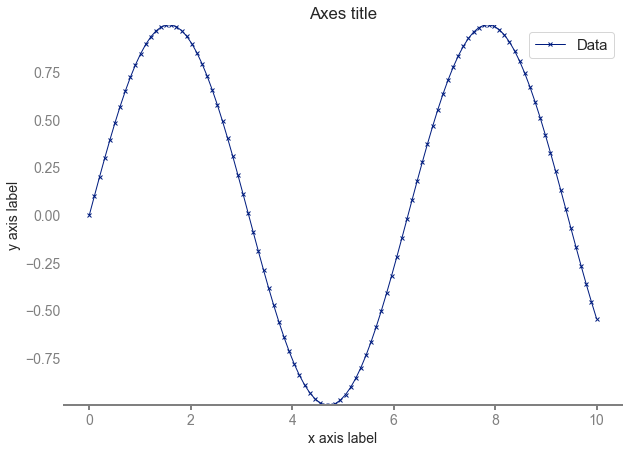

<Figure size 720x504 with 0 Axes>

In [3]:
# Example usage:
x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
ax.plot(x, y, marker='x', linestyle='-', label='Data')  # Choose appropriate marker and line styles (e.g., 'o' for circles, '-' for solid lines)
# try marker diamond 'd' or dot 'o', try linestyle dashed '--'

ax.set_title('Axes title')
ax.legend()
ax.set_ylabel('y axis label')
ax.set_xlabel('x axis label')

#plt.tight_layout()  # Adjust the spacing if needed
plt.show()  # Display the figure
plt.savefig('plot_example.png')  # Save the figure

- Sales & Prices data for companies
- GICS Sectors for each company 

In [26]:
path_clean_s = '/Users/pietrobicocchi/Desktop/project/data/cleaned/CompStat_sales.pkl'
path_clean_p = '/Users/pietrobicocchi/Desktop/project/data/cleaned/CompStat_prices.pkl'

# Load the saved DataFrame
returns_sales = pd.DataFrame(load_cleaned_data(path_clean_s))
returns_prices = pd.DataFrame(load_cleaned_data(path_clean_p))

In [27]:
gvkeys = list(returns_sales.columns)  # list of gvkeys of my sales data

sectors = extract_data('/Users/pietrobicocchi/Desktop/project/' + 'data/CompStat/sectors.csv')
key_to_sect = get_unique_sectors(sectors)
key_sect = gvkeys_to_sect(gvkeys, key_to_sect)
idx_by_sector, sector_dict, sector_indices, sector_labels = create_sectors(key_sect)

/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors["datadate"] = pd.to_datetime(sectors["datadate"])
/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sectors['gsector'] = sectors['gsector'].fillna(1)
/Users/pietrobicocchi/Desktop/project/notebooks/../src/csv_data/utils.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [4]:
# Numebers of gvkeys that are not contained into the dictionary -> assigned as others:
i=0
for key in gvkeys:
    try:
        sec = key_to_sect.loc[key]['sector_name']
        #print(sec)
        key_sect.append(sec)
    except KeyError:
        # Handle the KeyError condition here
        #print(f"KeyError occurred for key: {key}")
        i+=1
        key_sect.append('Other')  # or add a default value to the list
        
i #189 companies has been sectorized as Other since they didn't have a sector code. 

189

## Sales

### correlations

In [28]:
%%time
corr_sales = returns_sales.corr(method= 'pearson', min_periods=8)
corr_sales = corr_sales.replace([np.nan, np.inf, -np.inf], 0)

corr_prices = returns_prices.corr(method= 'pearson', min_periods=8)
corr_prices = corr_prices.replace([np.nan, np.inf, -np.inf], 0)

CPU times: user 776 ms, sys: 26.2 ms, total: 802 ms
Wall time: 804 ms


In [29]:
corr_prices

GVKEY,1004,1045,1050,1062,1072,1075,1076,1078,1104,1121,...,15106,15247,16668,16775,17072,17073,17252,19605,19661,20029
GVKEY,,,,,,,,,,,,,,,,,,,,,
1004,1.000000,0.522063,0.192853,0.033588,0.466924,0.127533,0.058621,0.159648,0.206380,0.257697,...,0.202339,0.303084,0.248129,-0.099105,0.212780,0.336766,0.193078,-0.068961,0.305026,0.234679
1045,0.522063,1.000000,0.244279,-0.110628,0.343027,0.283637,0.188838,0.155764,0.208545,0.165574,...,0.229818,0.247658,0.167687,-0.025213,0.127255,0.402691,0.200485,0.013651,0.222001,0.352409
1050,0.192853,0.244279,1.000000,-0.028821,0.127954,0.255608,0.172023,-0.069143,0.228892,0.213130,...,0.127723,0.207770,0.259941,-0.101775,0.019868,0.547689,0.131698,0.213060,0.172116,0.252634
1062,0.033588,-0.110628,-0.028821,1.000000,0.138194,-0.145910,0.048768,0.150372,0.113772,0.103447,...,-0.056815,0.021933,-0.019104,0.001870,0.039610,0.015186,-0.129643,0.085363,0.075445,0.032523
1072,0.466924,0.343027,0.127954,0.138194,1.000000,0.003467,0.026264,0.090592,0.209695,0.264154,...,0.162520,0.272832,-0.092278,0.047248,0.047563,0.070659,0.007505,0.137039,0.234109,-0.005178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17073,0.336766,0.402691,0.547689,0.015186,0.070659,0.410086,0.303415,0.147421,0.309662,0.249044,...,0.163748,0.447099,0.226223,-0.101505,0.097631,1.000000,0.365458,0.072148,0.091861,0.345055
17252,0.193078,0.200485,0.131698,-0.129643,0.007505,0.099619,0.156439,0.077242,0.181494,0.070536,...,0.022886,0.537976,0.135549,0.012932,0.125936,0.365458,1.000000,-0.208168,-0.004943,0.131021
19605,-0.068961,0.013651,0.213060,0.085363,0.137039,0.037189,0.092931,0.031704,0.196367,0.171104,...,0.077223,0.026071,-0.129801,0.063986,-0.002249,0.072148,-0.208168,1.000000,0.110198,-0.055899


In [777]:
%%time
eVal_s , eVec_s = getPCA(corr_sales)
eVal_p , eVec_p = getPCA(corr_prices)

CPU times: user 1.79 s, sys: 239 ms, total: 2.03 s
Wall time: 1.04 s


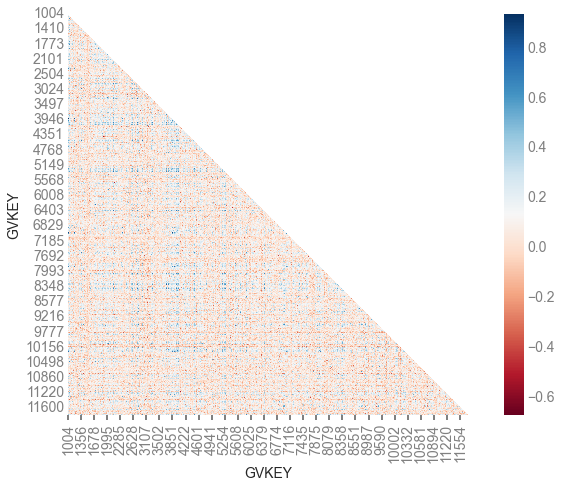

In [31]:
# Create a mask to hide some cells
mask = np.zeros_like(corr_sales)
mask[np.triu_indices_from(mask)] = True
colormap = plt.cm.RdBu

# Create the heatmap with the mask
sns.heatmap(corr_sales, mask=mask, cmap=colormap, square=True, annot=False)

# Show the plot
plt.show()

- Marcenko-Pastur distribution for eigenvalues

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_90313/1576557803.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


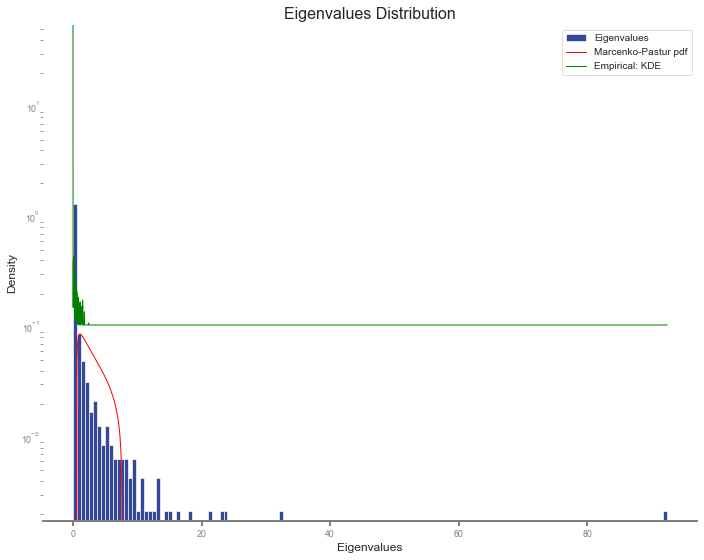

In [71]:
fig = visualize_pm_eig(returns_sales.shape[1], returns_sales.shape[0], eVal_s)
fig.show()

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_91050/260142801.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels(range(int(maximum-10), int(maximum+10)), ha='right')
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


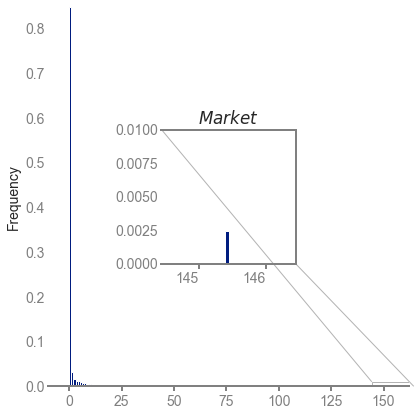

In [428]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
def PCA_plot(df, abs, ord, bins, zoom, loc):
    '''
    # df : (pandas.DataFrame) dataframe with only one column
    # abs, ord : (int, int) size of the figure
    # bins : (int) number of bins for the histogram
    # zoom : (int) size of the zoom window
    # loc : (str) location of the zoom window ['center', 'lower', ...etc]
    '''
    maximum = list(df.max())[0] # It is the value of the highest eigenvalue
    fig, ax = plt.subplots(figsize=(6,6))
    # Main window
    df.plot(kind = 'hist', bins = 150, ax=ax, density=True,  label='Main window', legend = False)
    ax.set_xlim(left = -10)
    # Créer l'axe pour le zoom
    axins = zoomed_inset_axes(ax, zoom = zoom, loc = loc)
    # Zoom window
    df.plot(kind = 'hist', bins = bins, ax=axins, density=True,  label='Zoom window', legend = False)

    axins.set_xlim(maximum-10, maximum+10)
    axins.set_ylim(0, 0.01)
    axins.spines['right'].set_visible(True)
    axins.spines['top'].set_visible(True)
    axins.set_xticklabels(range(int(maximum-10), int(maximum+10)), ha='right')

    #axins.set_yticks([0, 0.005, 0.01])
    axins.set_ylabel('')
    axins.set_title('$Market$')
    axins.set_aspect(((maximum+10)-(maximum-10))/(0.01-0))

    # Draw a border around the zoomed area
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.7")

    
    return plt.show()

PCA_plot(pd.DataFrame(np.diag(eVal_p)), 10,10, 300, 30, loc='center')

- modes

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_91050/4215702306.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


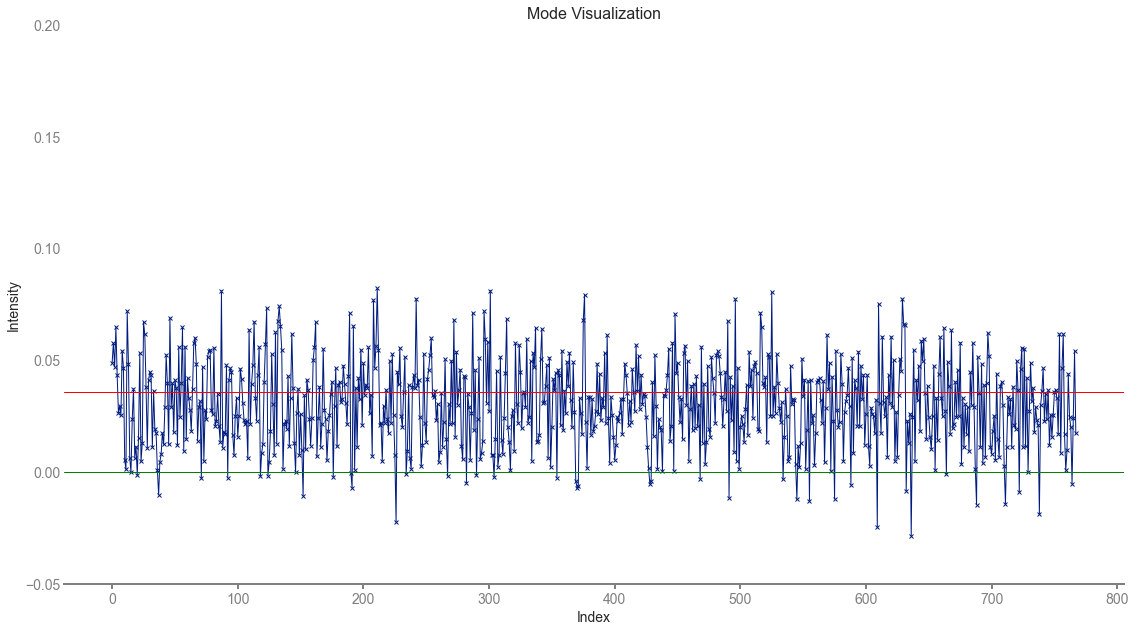

In [778]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = -1)
fig.show()

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_91050/300541810.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


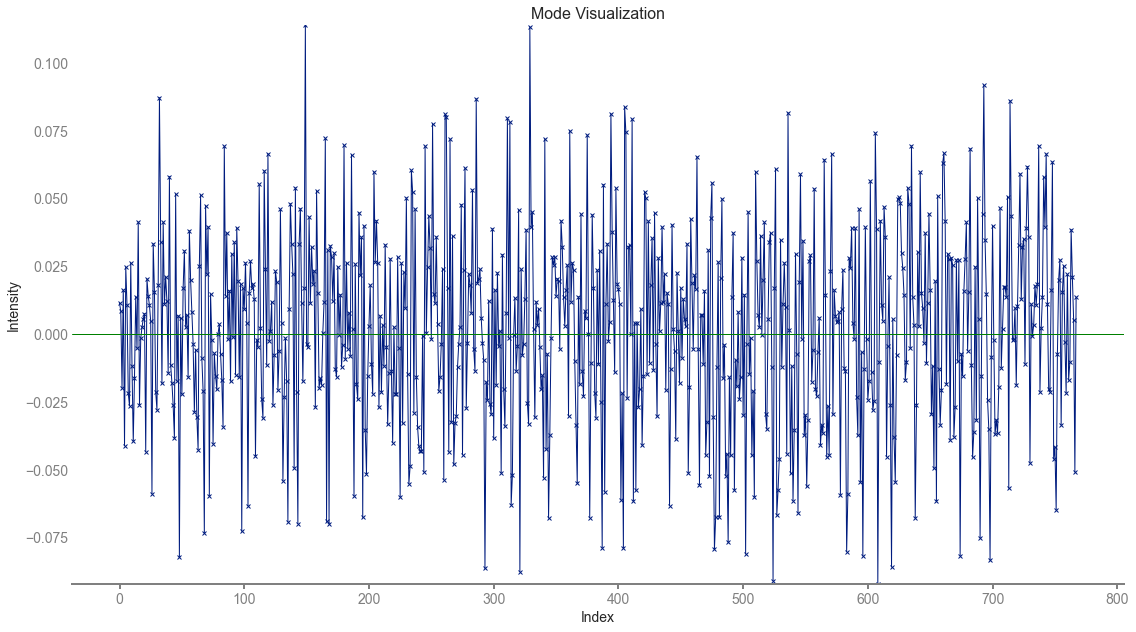

In [33]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = -2)
fig.show()

/var/folders/x6/85hsl6vd4xn8qtg06p6gf4j80000gn/T/ipykernel_91050/3264894795.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


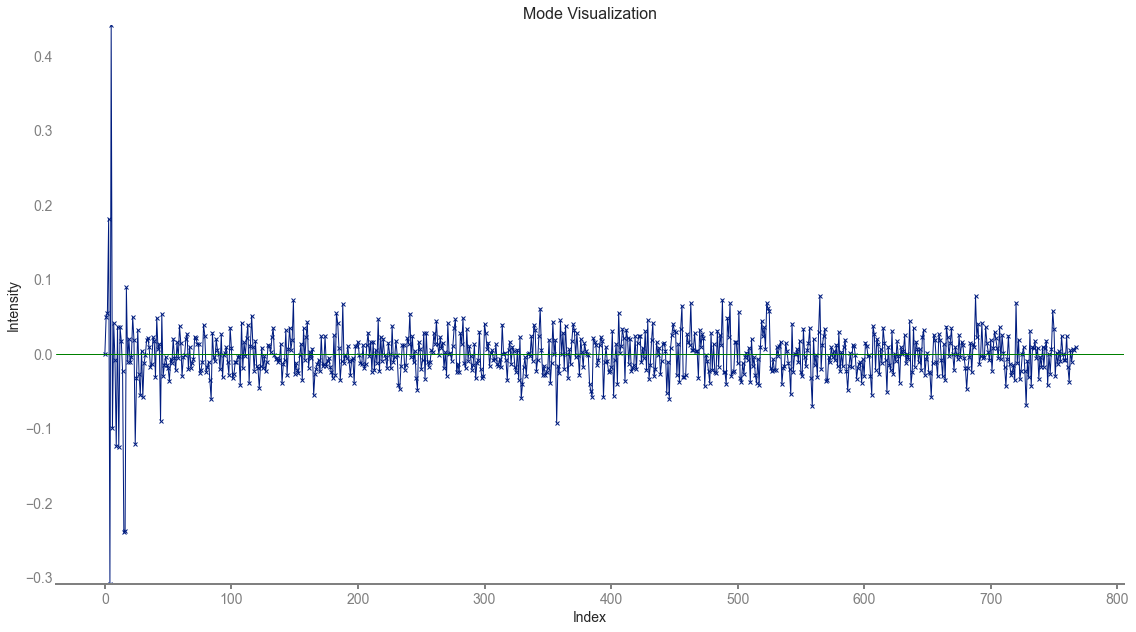

In [34]:
fig = visualize_mode(eVec = eVec_s, corr = corr_sales, mode = 0)
fig.show()

- Plotting mode by sectors

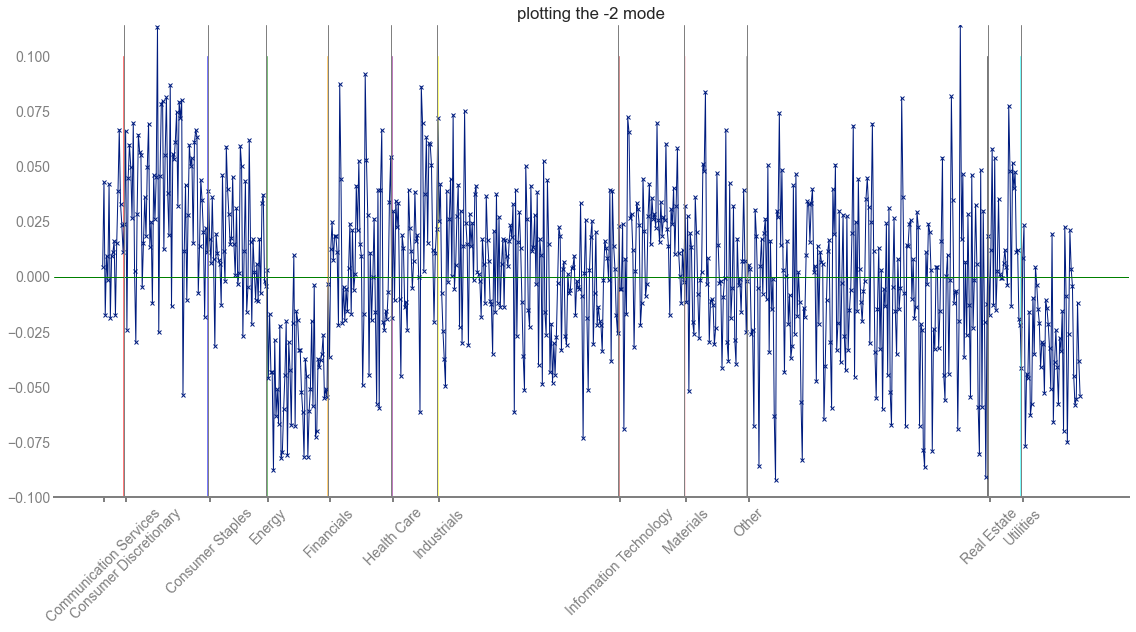

In [780]:
#plt.plot(eVec_s[idx_by_sector, -1].flatten())
plot_by_sector(mode=-2, tk_ind = key_sect, eVec = eVec_s)

- Density of eigenvectors

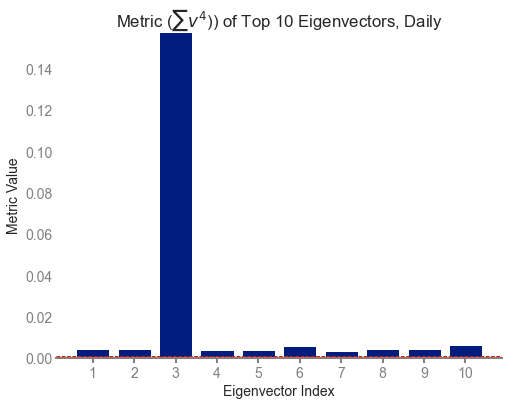

In [23]:
metric = density_eigenvector_metric(eigenvectors = eVec_s, number_eVec=10)

# Plot the metric values
plt.figure(figsize=(8, 6))
plt.bar(range(1, 11), metric)
plt.xlabel('Eigenvector Index')
plt.ylabel('Metric Value')
plt.title('Metric ($\sum{v^4}$)) of Top 10 Eigenvectors, Daily')
plt.xticks(range(1, 11))

plt.axhline(y=1/len(eVec_s), color='red', linestyle='--')

plt.show()

- mode coefficients

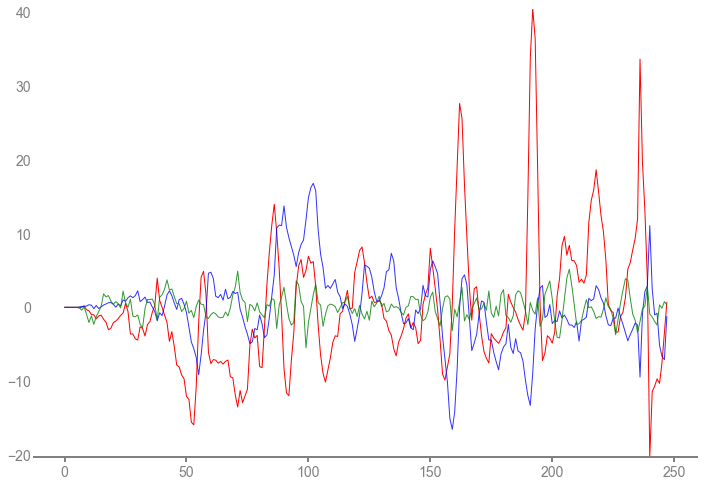

In [24]:
plt.rcParams["figure.autolayout"] = True
pl1=plt.plot(mode_coefficient(returns_sales, 0), alpha=1, color='r')
pl2=plt.plot(mode_coefficient(returns_sales, 1), alpha =0.8, color='b')
pl3=plt.plot(mode_coefficient(returns_sales, 60), alpha =0.8, color='g')

plt.show()

tells you how much every mode is significant at each instant in time

In [ ]:
periods, power_spectra = analyze_mode_coefficients(returns_sales)
fig = plot_mode_analysis(periods, power_spectra, returns_sales)
fig.show()

In [50]:
print(f"the period of the first mode is: {periods[0]}")
print(f"the period of the second mode is: {periods[1]}")

the period of the first mode is: 248.0
the period of the second mode is: 248.0


I don't like this result. Why this peak at low frequency and consequently the majority of the periods hit the T = 248, i.e. the length of the time series. A reason could be the Spectral leakage problem.

https://fischerbach.medium.com/introduction-to-fourier-analysis-of-time-series-42151703524a

In [19]:
# Testing the function:
x = np.linspace(0,100,num= 1000)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.cos(np.cos(x))
data0 = {}

for key in range(50):
    data0[str(key)] = np.sin(x)
    
y = pd.DataFrame(data0)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value

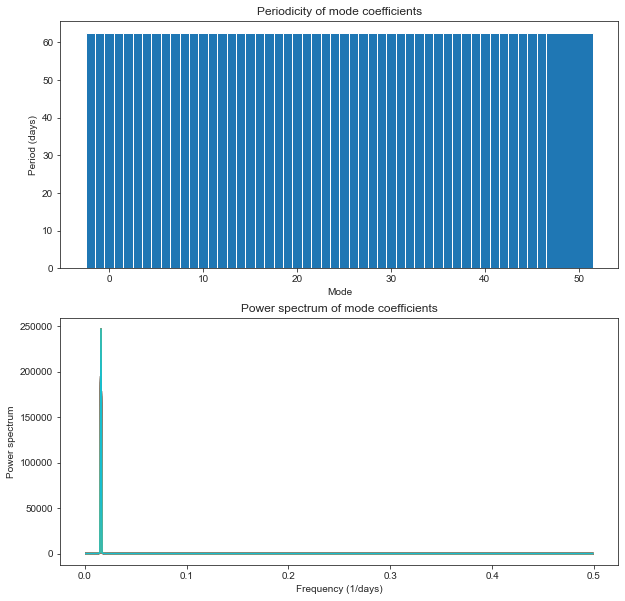

In [77]:
periods0, power_spectra0 = analyze_mode_coefficients(y)
fig = plot_mode_analysis(periods0, power_spectra0, y)
fig.show()

### Lead-lag correlations

In [ ]:
lagged_corr=lagged_correlation(returns_sales, tau = 50)
lagged_corr

In [38]:
lagged_corr = lagged_corr.replace([np.nan, np.inf, -np.inf], 0)
u, s, v = np.linalg.svd(lagged_corr.values) 

In [88]:
# Calculate the proportion of variance explained by each principal component
variance_explained = (s ** 2) / np.sum(s ** 2)

# Plot the variance explained
plt.plot(np.arange(1, len(variance_explained)+1), variance_explained, 'ro-', linewidth=2)
plt.title('Screen Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

NameError: name 's' is not defined

calling x_i(t) the returns and g_i(t) the sales growth,

compute the averaged correlation function, i.e. $ E[ x_i(t) g_i(t+T)]$  where the average runs over i and t. Jose has done this in the past, and you will see that you will get a peak (I think at 6 months), meaning that returns now correlate positively with growth of sales 6 months from now.

In [37]:
###
import src.csv_data.extract as ex
df = ex.extract_data('/Users/pietrobicocchi/Desktop/project/' + 'data/CompStat/crsp_ccm_inventories_sales.csv')
sales, prices = df_to_sales(df)
sales_keys = returns_sales.keys()
tailored_prices = tailored_clean(prices, sales_keys)
###
tailored_prices
returns_sales

periods = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,
          26,27,28,29,30]  # data are sampled quarterly. we range from zero lag to 2 years lag


average_prices_sales = double_average_lags(periods, tailored_prices, returns_sales) # Mind the order of the inputs
average_sales_prices = double_average_lags(periods, returns_sales, tailored_prices) # Mind the order of the inputs
average_sales_sales = double_average_lags(periods, returns_sales, returns_sales)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/pietrobicocchi/Desktop/project/notebooks/../src/funcs.py:264: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  corr_series = pd.Series(index=sales.columns)  # initialize the series


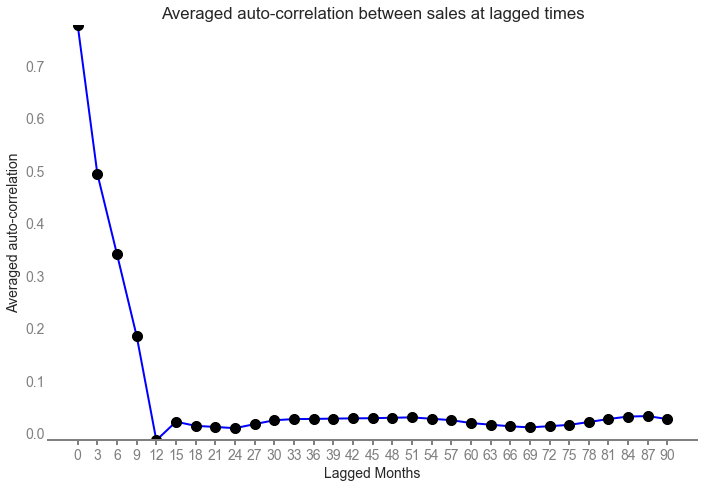

In [38]:
quarters = [period * 3 for period in periods]  # Convert periods to quarterly values
fig, ax = plt.subplots()
ax.plot(quarters, average_sales_sales, '-o', color='blue', linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')

# Add black circles around the sampled points
for i, j in zip(quarters, average_sales_sales):
    ax.plot(i, j, 'o', markersize=10, color='black')

ax.set_xticks(quarters)
ax.set_xlabel('Lagged Months')
ax.set_ylabel('Averaged auto-correlation')
ax.set_title('Averaged auto-correlation between sales at lagged times')

plt.show()

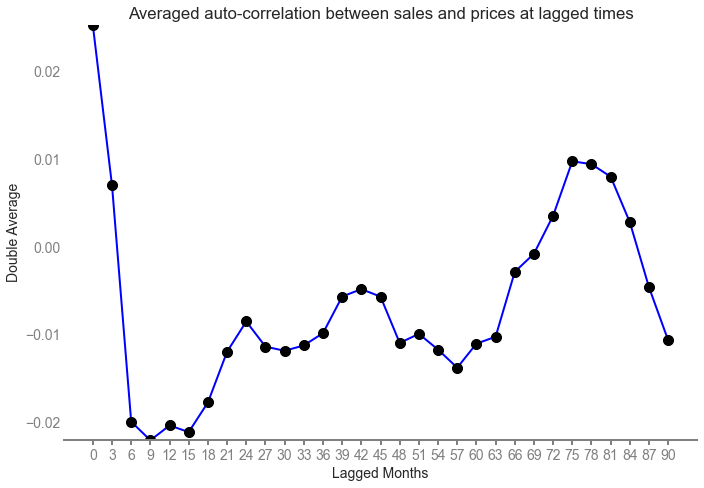

In [39]:
quarters = [period * 3 for period in periods]  # Convert periods to quarterly values
fig, ax = plt.subplots()
ax.plot(quarters,average_sales_prices, '-o', color='blue', linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')

# Add black circles around the sampled points
for i, j in zip(quarters, average_sales_prices):
    ax.plot(i, j, 'o', markersize=10, color='black')

ax.set_xticks(quarters)
ax.set_xlabel('Lagged Months')
ax.set_ylabel('Double Average')
ax.set_title('Averaged auto-correlation between sales and prices at lagged times')

plt.show()

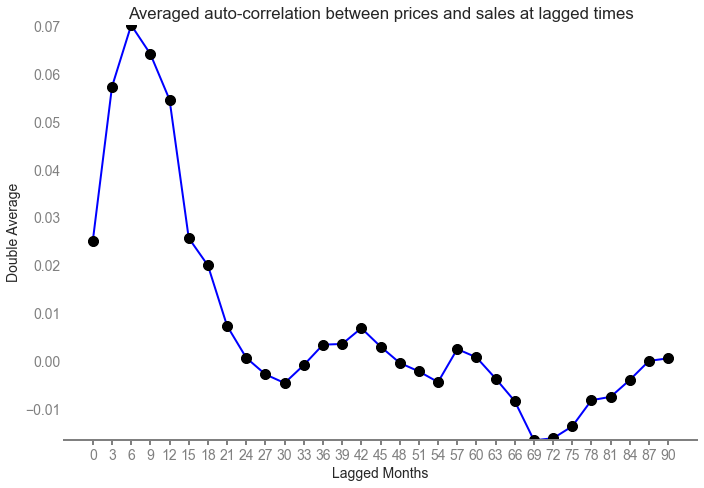

In [40]:
quarters = [period * 3 for period in periods]  # Convert periods to quarterly values
fig, ax = plt.subplots()
ax.plot(quarters, average_prices_sales, '-o', color='blue', linewidth=2, markersize=8, markerfacecolor='white', markeredgewidth=2, markeredgecolor='black')

# Add black circles around the sampled points
for i, j in zip(quarters, average_prices_sales):
    ax.plot(i, j, 'o', markersize=10, color='black')

ax.set_xticks(quarters)
ax.set_xlabel('Lagged Months')
ax.set_ylabel('Double Average')
ax.set_title('Averaged auto-correlation between prices and sales at lagged times')

plt.show()

This suggests that there is some lead-lag effect between sales and returns. The thing you coud look at is the SVD of the matrix  C_{ij} = x_i(t) g_j(t+T), where now T is fixed at 6 months. You can then do the singular value decomposition. If the lead lag is perfect for firm i (meaning that the main explanation for sales - returns correlation is that the interaction between these two quantities at this timescale happens mainly for the **same firm** and cross-firm effects are negligible) then what you should see is that the left and right singular vectors corresponding to the largest singular value should pretty much overlap. I think that we'll see that this isn't the case, so it may explain why these dynamics are a bit different. We may find for example that the growth of a firm in sector S correlates positively with the returns **of the whole sector** at some other time point (or vice versa). I think this would be a bit in line with what JPB told us last week.


In [41]:
lag_6_months=lagged_correlation_mixed(ret1 = tailored_prices, ret2 = returns_sales, tau = 2)
lag_6_months

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
GVKEY,,,,,,,,,,,,,,,,,,,,,
1004,0.0532,0.1447,0.0792,0.0695,-0.0835,0.0334,0.0699,0.0181,0.0499,0.134,...,0.0145,-0.0289,0.1032,0.0628,0.0026,-0.0583,0.0608,0.0069,0.058,-0.0296
1045,-0.03,0.095,0.0182,0.061,-0.004,0.0291,0.1931,0.039,0.0222,0.0714,...,0.0114,0.0115,0.0802,0.0468,-0.024,0.0057,0.0054,0.0286,-0.0122,0.0182
1062,-0.1012,-0.0474,0.1661,0.0437,0.0116,-0.0038,0.0933,0.1332,-0.0194,0.0649,...,0.0436,-0.0116,0.0497,-0.0013,0.0159,0.0048,-0.0199,-0.0,0.042,0.0407
1072,-0.0137,-0.0237,-0.0018,0.117,-0.0208,-0.0473,0.0152,0.1466,0.0535,0.1554,...,0.0134,-0.0162,-0.0325,0.0081,-0.0435,-0.0111,-0.0096,0.0022,0.0179,0.0077
1075,-0.0326,0.0502,0.003,0.0024,0.0653,0.0375,-0.0494,0.0398,0.0208,-0.0053,...,0.0248,-0.0004,0.1244,-0.0358,-0.1027,-0.0042,-0.0079,0.0433,-0.0428,0.0127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13714,-0.04,0.1024,0.0861,0.0658,0.0107,0.0192,0.0149,0.079,0.079,0.0953,...,-0.0191,-0.0719,0.0394,0.0501,-0.0713,-0.0072,-0.0988,0.057,0.0716,0.0221
14253,-0.0202,0.0056,0.0227,-0.0354,0.0233,-0.0193,0.0064,0.0037,-0.0287,-0.0187,...,-0.0117,-0.0548,0.077,0.0252,0.0811,0.0621,-0.0185,-0.0455,-0.0183,-0.0121
15106,-0.0058,0.007,-0.0265,0.0486,-0.0022,0.0132,-0.0188,0.0787,0.0385,0.0532,...,-0.0374,0.0086,-0.0127,-0.0021,-0.0006,0.0129,0.0177,0.0282,0.0012,0.0189


In [42]:
lag_6_months = lag_6_months.replace([np.nan, np.inf, -np.inf], 0)
u, s, v = np.linalg.svd(lag_6_months.values) 

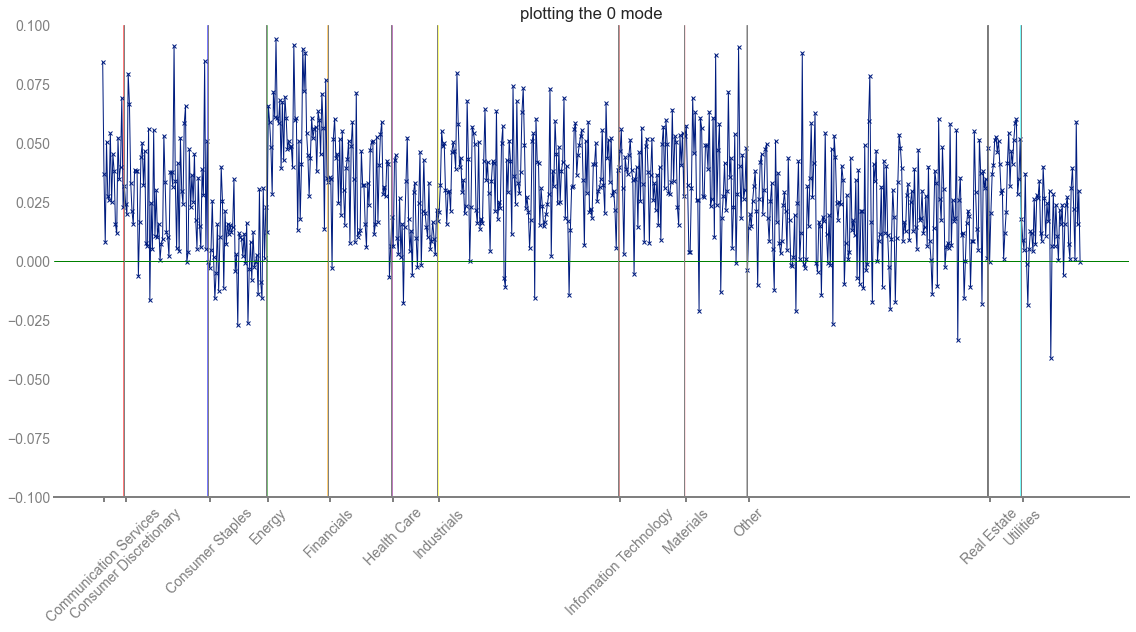

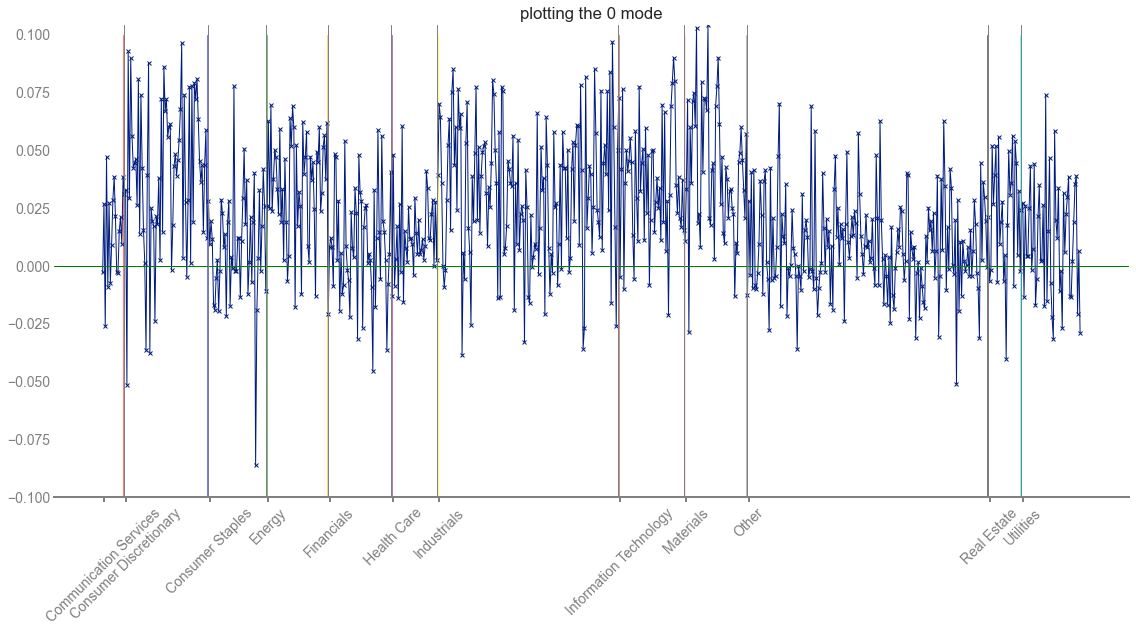

In [43]:
plot_by_sector(mode=0, tk_ind = key_sect, eVec = u)
plot_by_sector(mode=0, tk_ind = key_sect, eVec = v.T)

scatterplot for market mode of prices and sales

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='first Left Singular Vector', ylabel='first Right Singular Vector'>

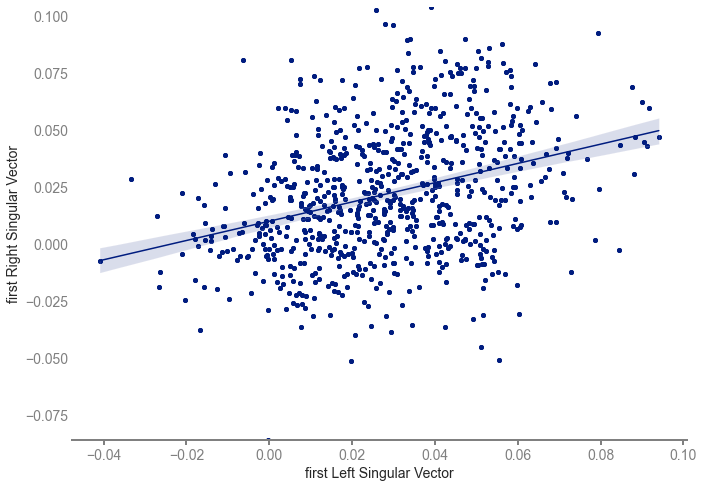

In [49]:
plt.scatter(u[:,0], v.T[:,0])
plt.xlabel('first Left Singular Vector')
plt.ylabel('first Right Singular Vector')
sns.regplot(u[:,0], v.T[:,0]) #create scatterplot with regression line and confidence interval lines

### CPCA for lead lag effects

In [757]:
def complex_correlation_matrix(matrix1, matrix2):
    """
    Compute the complex correlation matrix between two sets of variables.

    Args:
        matrix1 (numpy.ndarray): First matrix of shape (N, P).
        matrix2 (numpy.ndarray): Second matrix of shape (N, Q).

    Returns:
        numpy.ndarray: Complex correlation matrix of shape (P, Q).
    """
    # Check dimensions
    if matrix1.shape[0] != matrix2.shape[0]:
        raise ValueError("Matrices must have the same number of rows.")

    # Get dimensions
    N = matrix1.shape[0]
    P = matrix1.shape[1]
    Q = matrix2.shape[1]

    # Initialize correlation matrix
    corr_matrix = np.zeros((P, Q), dtype=np.complex128)

    # Compute complex correlation matrix
    for i in range(P):
        for j in range(Q):
            column1 = matrix1[:, i]
            column2 = matrix2[:, j]
            corr_matrix[i, j] = np.vdot(column2, column1) / N

    return corr_matrix
pd.DataFrame(complex_correlation_matrix(analytic_signal_p, analytic_signal_s))

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.650000e-35+0.000000e+00j,-3.996525e-36+0.000000e+00j,-2.062500e-36+0.000000e+00j,-1.393227e-35+0.000000e+00j,-7.528034e-36+0.000000e+00j,-6.988428e-36+0.000000e+00j,-7.528034e-36+0.000000e+00j,1.870402e-35+0.000000e+00j,-4.255295e-36+0.000000e+00j,0.0+0.0j,...,-1.769650e-35+0.000000e+00j,3.117337e-36+0.000000e+00j,7.225774e-36+0.000000e+00j,0.0+0.0j,1.273189e-35+0.000000e+00j,-4.094254e-36+0.000000e+00j,4.614790e-36+0.000000e+00j,1.139454e-35+0.000000e+00j,0.0+0.0j,-8.556470e-36+0.000000e+00j
1,-3.996525e-36+0.000000e+00j,9.680130e-37+0.000000e+00j,4.995657e-37+0.000000e+00j,3.374586e-36+0.000000e+00j,1.823393e-36+0.000000e+00j,1.692693e-36+0.000000e+00j,1.823393e-36+0.000000e+00j,-4.530369e-36+0.000000e+00j,1.030691e-36+0.000000e+00j,0.0+0.0j,...,4.286335e-36+0.000000e+00j,-7.550615e-37+0.000000e+00j,-1.750181e-36+0.000000e+00j,0.0+0.0j,-3.083837e-36+0.000000e+00j,9.916843e-37+0.000000e+00j,-1.117765e-36+0.000000e+00j,-2.759913e-36+0.000000e+00j,0.0+0.0j,2.072494e-36+0.000000e+00j
2,-2.062500e-36+0.000000e+00j,4.995657e-37+0.000000e+00j,2.578125e-37+0.000000e+00j,1.741534e-36+0.000000e+00j,9.410042e-37+0.000000e+00j,8.735534e-37+0.000000e+00j,9.410042e-37+0.000000e+00j,-2.338003e-36+0.000000e+00j,5.319119e-37+0.000000e+00j,0.0+0.0j,...,2.212063e-36+0.000000e+00j,-3.896671e-37+0.000000e+00j,-9.032217e-37+0.000000e+00j,0.0+0.0j,-1.591486e-36+0.000000e+00j,5.117818e-37+0.000000e+00j,-5.768488e-37+0.000000e+00j,-1.424317e-36+0.000000e+00j,0.0+0.0j,1.069559e-36+0.000000e+00j
3,-1.393227e-35+0.000000e+00j,3.374586e-36+0.000000e+00j,1.741534e-36+0.000000e+00j,1.176413e-35+0.000000e+00j,6.356522e-36+0.000000e+00j,5.900889e-36+0.000000e+00j,6.356522e-36+0.000000e+00j,-1.579330e-35+0.000000e+00j,3.593087e-36+0.000000e+00j,0.0+0.0j,...,1.494257e-35+0.000000e+00j,-2.632217e-36+0.000000e+00j,-6.101299e-36+0.000000e+00j,0.0+0.0j,-1.075055e-35+0.000000e+00j,3.457107e-36+0.000000e+00j,-3.896637e-36+0.000000e+00j,-9.621321e-36+0.000000e+00j,0.0+0.0j,7.224913e-36+0.000000e+00j
4,-7.528034e-36+0.000000e+00j,1.823393e-36+0.000000e+00j,9.410042e-37+0.000000e+00j,6.356522e-36+0.000000e+00j,3.434624e-36+0.000000e+00j,3.188431e-36+0.000000e+00j,3.434624e-36+0.000000e+00j,-8.533606e-36+0.000000e+00j,1.941455e-36+0.000000e+00j,0.0+0.0j,...,8.073931e-36+0.000000e+00j,-1.422268e-36+0.000000e+00j,-3.296719e-36+0.000000e+00j,0.0+0.0j,-5.808854e-36+0.000000e+00j,1.867981e-36+0.000000e+00j,-2.105472e-36+0.000000e+00j,-5.198695e-36+0.000000e+00j,0.0+0.0j,3.903842e-36+0.000000e+00j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-4.094254e-36+0.000000e+00j,9.916843e-37+0.000000e+00j,5.117818e-37+0.000000e+00j,3.457107e-36+0.000000e+00j,1.867981e-36+0.000000e+00j,1.734085e-36+0.000000e+00j,1.867981e-36+0.000000e+00j,-4.641153e-36+0.000000e+00j,1.055895e-36+0.000000e+00j,0.0+0.0j,...,4.391150e-36+0.000000e+00j,-7.735254e-37+0.000000e+00j,-1.792979e-36+0.000000e+00j,0.0+0.0j,-3.159248e-36+0.000000e+00j,1.015934e-36+0.000000e+00j,-1.145098e-36+0.000000e+00j,-2.827402e-36+0.000000e+00j,0.0+0.0j,2.123174e-36+0.000000e+00j
764,4.614790e-36+0.000000e+00j,-1.117765e-36+0.000000e+00j,-5.768488e-37+0.000000e+00j,-3.896637e-36+0.000000e+00j,-2.105472e-36+0.000000e+00j,-1.954553e-36+0.000000e+00j,-2.105472e-36+0.000000e+00j,5.231220e-36+0.000000e+00j,-1.190139e-36+0.000000e+00j,0.0+0.0j,...,-4.949433e-36+0.000000e+00j,8.718700e-37+0.000000e+00j,2.020935e-36+0.000000e+00j,0.0+0.0j,3.560909e-36+0.000000e+00j,-1.145098e-36+0.000000e+00j,1.290684e-36+0.000000e+00j,3.186873e-36+0.000000e+00j,0.0+0.0j,-2.393110e-36+0.000000e+00j
765,1.139454e-35+0.000000e+00j,-2.759913e-36+0.000000e+00j,-1.424317e-36+0.000000e+00j,-9.621321e-36+0.000000e+00j,-5.198695e-36+0.000000e+00j,-4.826054e-36+0.000000e+00j,-5.198695e-36+0.000000e+00j,1.291659e-35+0.000000e+00j,-2.938613e-36+0.000000e+00j,0.0+0.0j,...,-1.222082e-35+0.000000e+00j,2.152764e-36+0.000000e+00j,4.989961e-36+0.000000e

In [756]:
arr1 = np.array([2+3j,5+6j])
arr2 = np.array([9+10j,11+12j])
np.vdot(arr1,arr1)


(74+0j)

In [758]:
from scipy.signal import hilbert

def cpca(returns):
    # Perform Hilbert transform on the data
    analytic_signal = hilbert(returns, axis=0)
    analytic_signal = np.matrix(analytic_signal)
    
    # Calculate the mean and standard deviation of each column
    mean = np.mean(analytic_signal, axis=0)
    std_dev = np.std(analytic_signal, axis=0)

    # Normalize each column
    analytic_signal = (analytic_signal - mean) / std_dev  # now it's normalized!
    
    # Compute the covariance matrix
    im_c = (1/len(returns))*(np.matmul(analytic_signal.H, analytic_signal).imag*1j)
    c = pd.DataFrame(returns).corr()
    corr = im_c + c
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(corr)
    
    # Sort the eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    
    return corr, eigenvalues, eigenvectors

In [711]:
from matplotlib.patches import Circle


def plotting_complex_plane(complex_array, title):

    # Extract the real and imaginary parts and modulus
    real_part = np.real(complex_array)
    imaginary_part = np.imag(complex_array)
    modulus = np.abs(complex_array)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the complex array
    ax.scatter(real_part, imaginary_part, color='blue', marker='x')

    # Create a circle patch
    circle1 = Circle((0, 0), radius=0.05, edgecolor='grey', facecolor='none', linewidth=1, linestyle = '--')
    #circle2 = Circle((0, 0), radius=0.1, edgecolor='grey', facecolor='none', linewidth=1, linestyle = '--')

    # Add the circle patch to the plot
    ax.add_patch(circle1)
    #ax.add_patch(circle2)

    # Set the x and y limits
    #ax.set_xlim([-4, 4])
    #ax.set_ylim([-4, 4])

    # Set labels and title
    ax.set_xlabel('Real')
    ax.set_ylabel('Imaginary')
    ax.set_title(title)

    # Display the plot
    plt.grid(True)
    plt.show()

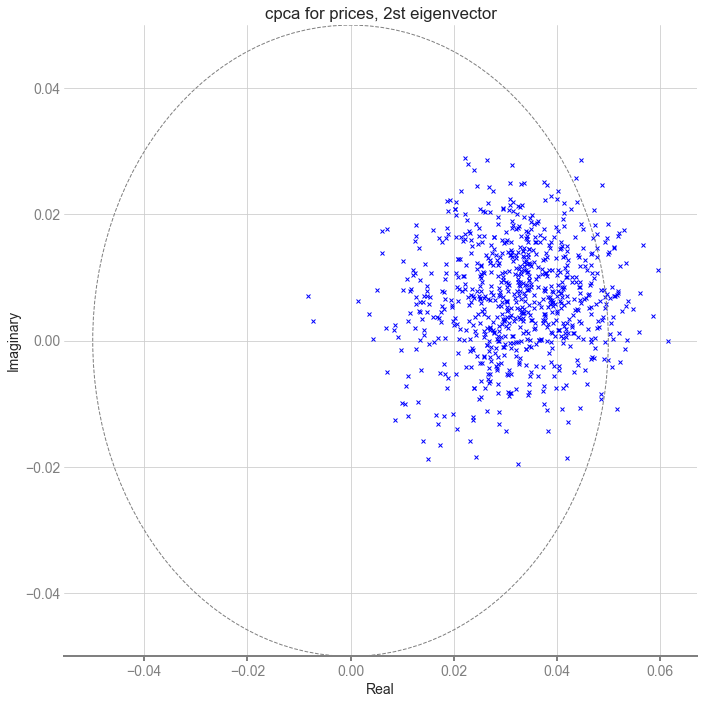

In [767]:
compl_corr, eVal_cpca, eVec_cpca = cpca(returns_prices)
plotting_complex_plane(eVec_cpca[:,0], title = "cpca for prices, 2st eigenvector")

In [772]:
eVec_cpca[:,0]

array([ 0.0446876 +2.85566774e-02j,  0.04628661+7.42279174e-03j,
        0.0349757 -9.27683443e-04j,  0.00432755+2.17294889e-04j,
        0.03192644+1.06311134e-02j,  0.03521863+3.31040174e-03j,
        0.01839844-5.28202484e-03j,  0.02318518-1.67058817e-03j,
        0.04028629+1.74596992e-03j,  0.02521492+1.05835725e-02j,
        0.03760801-7.10136243e-03j,  0.03569007+1.56624034e-02j,
        0.0051513 +8.09237535e-03j,  0.03295547-2.72956704e-03j,
        0.04405907+4.83945144e-03j,  0.01730901-1.65001367e-02j,
        0.02387021-7.55729451e-03j,  0.02177332+1.58381619e-02j,
        0.03910507+1.12079411e-02j,  0.03578663+1.63676668e-02j,
        0.02505662+8.72715995e-03j,  0.03998047+2.25021401e-02j,
        0.03029578+1.59827721e-02j,  0.04515362+1.47512872e-02j,
        0.02695551+2.13532773e-03j,  0.02955627-1.07375322e-03j,
        0.04024604+2.36562124e-02j,  0.0307115 +2.06336398e-02j,
        0.0377187 +2.23527623e-02j,  0.03738998+2.77783863e-03j,
        0.03457358+9.6698

[*********************100%***********************]  30 of 30 completed


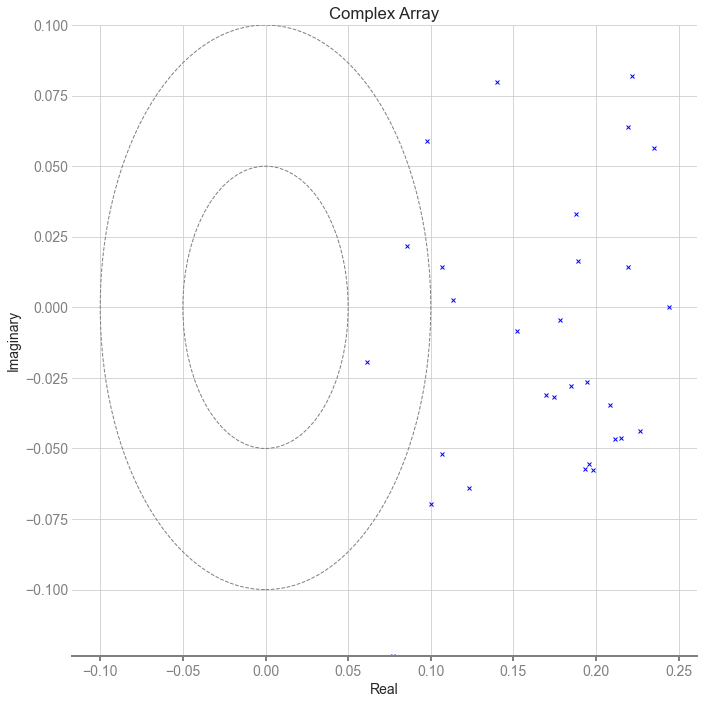

In [545]:
# TESTING
import yfinance as yf
# Define the list of ticker symbols for the top 30 companies
ticker_symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "JPM", "V", "JNJ", "WMT", "PG",
                  "TSLA", "UNH", "VZ", "MA", "NVDA", "HD", "INTC", "PYPL", "ADBE", "CMCSA",
                  "PFE", "T", "NFLX", "DIS", "CSCO", "XOM", "KO", "MRK", "BAC", "ABBV"]
# Fetch historical stock price data for the top 30 companies
data = yf.download(ticker_symbols, period="2y")
# Extract the adjusted close prices from the data
adj_close_prices = data['Adj Close']
# Calculate the daily returns
returns = adj_close_prices.pct_change()
returns = returns.fillna(0).replace([np.inf, -np.inf], 0)

compl_corr, eVal_cpca, eVec_cpca = cpca(returns)
plotting_complex_plane(eVec_cpca[:,0])

In [548]:
# Polar form 
import cmath

def total_sum(complex_vector):    
    # Compute the polar form of each component
    polar_form = [cmath.polar(c) for c in complex_vector]

    # Extract the magnitude and angle (in radians) from the polar form
    magnitudes = [p[0] for p in polar_form]
    angles = [p[1] for p in polar_form]

    # Compute the sum of the absolute values of the angles
    angle_sum = sum(abs(angle) for angle in angles)
    
    return angle_sum

total_sum(eVec_cpca[:,0])

7.883495906539908

In [773]:
# Perform Hilbert transform on the data
analytic_signal_p = hilbert(tailored_prices)
analytic_signal_p = np.matrix(analytic_signal_p)
analytic_signal_s = hilbert(returns_sales)
analytic_signal_s = np.matrix(analytic_signal_s)

# Calculate the mean and standard deviation of each column
mean = np.mean(analytic_signal_p, axis=0)
std_dev = np.std(analytic_signal_p, axis=0)
analytic_signal_p = (analytic_signal_p - mean) / std_dev  # now it's normalized!

mean = np.mean(analytic_signal_s, axis=0)
std_dev = np.std(analytic_signal_s, axis=0)
analytic_signal_s = (analytic_signal_s - mean) / std_dev  # now it's normalized!

def mixed_correlation(matrix1, matrix2):
    correlation_matrix = np.corrcoef(matrix1.T, matrix2.H)
    return correlation_matrix[:matrix1.shape[1], matrix1.shape[1]:]

mixed_correlation_matrix = mixed_correlation(analytic_signal_p, analytic_signal_s)
pd.DataFrame(mixed_correlation_matrix)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.021893-0.071492j,0.060954+0.016997j,-0.016946+0.026443j,-0.009257-0.010163j,0.027460-0.024993j,0.023923+0.021327j,0.023960-0.013230j,0.030642+0.049288j,-0.027291-0.008972j,0.043511-0.016795j,...,-0.029828+0.020568j,0.019792+0.017178j,-0.024714+0.000334j,0.059466-0.026170j,0.022827+0.095437j,-0.066219-0.034396j,0.110567-0.018633j,0.001520+0.107575j,-0.018453+0.019720j,-0.053323+0.048316j
1,0.054897-0.006871j,-0.014424+0.077063j,-0.088740-0.003871j,0.004164-0.089467j,0.091360+0.019537j,-0.004787+0.065655j,-0.001615+0.026771j,-0.030741+0.045926j,-0.050767-0.014147j,0.026601-0.023956j,...,-0.011930+0.002206j,-0.070231+0.036794j,-0.041169-0.072831j,0.067342+0.001647j,-0.053643+0.058765j,-0.003169-0.077931j,0.077866+0.058029j,-0.046376+0.066591j,-0.051090+0.020604j,-0.043154-0.040726j
2,-0.020673+0.047952j,-0.037918+0.004313j,-0.021844-0.027099j,0.052760+0.018948j,-0.051360+0.093452j,-0.095166-0.018353j,-0.023319-0.042658j,-0.003418-0.013735j,-0.023633-0.038010j,0.035843-0.025757j,...,-0.010356-0.015845j,0.010477-0.015705j,0.018649-0.020153j,0.048462+0.041961j,-0.052436+0.030983j,0.032962-0.033038j,0.037816+0.069275j,-0.050593+0.074214j,-0.078183-0.026706j,0.034726-0.012776j
3,-0.032477-0.008551j,-0.007760+0.033255j,-0.074407+0.007225j,-0.069851-0.026515j,-0.034612-0.105962j,0.069271-0.047050j,0.031470+0.004368j,0.006109+0.032057j,-0.021936-0.044778j,0.086761+0.000794j,...,-0.001739+0.010288j,-0.086571+0.060503j,-0.046413-0.069378j,0.010613+0.020743j,-0.052811-0.013332j,0.007204-0.023865j,0.015722+0.035356j,-0.077461+0.039034j,-0.022607-0.070396j,0.010541+0.035914j
4,0.027679-0.002464j,-0.046937+0.068866j,-0.079182-0.048904j,0.012785-0.081143j,0.105753+0.003424j,-0.010126+0.099764j,-0.022725+0.006520j,-0.027025+0.022941j,0.031450-0.014610j,-0.016447+0.101819j,...,-0.024360-0.025322j,-0.038817-0.108475j,0.090876-0.046218j,0.018005+0.028144j,0.012617+0.000848j,0.015782-0.001122j,0.026255+0.050928j,-0.058670+0.015477j,0.019228-0.009032j,-0.033806+0.017857j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,-0.022941+0.050182j,-0.094885+0.001742j,-0.050349-0.061374j,-0.016208-0.078464j,0.064592-0.061533j,0.071837+0.010707j,0.042138+0.058980j,-0.047502+0.053891j,-0.011207-0.024540j,0.016409+0.022332j,...,-0.018500-0.088117j,0.058500+0.070795j,-0.103565+0.010186j,0.021614-0.042859j,-0.069815+0.022724j,-0.003098-0.144384j,0.148625-0.003680j,0.040072+0.116122j,-0.064299+0.075337j,-0.032368+0.001089j
764,-0.073066-0.063854j,0.021937-0.075733j,0.025107-0.011457j,0.018492-0.022706j,0.029460+0.024537j,-0.033841+0.018113j,-0.015904-0.022336j,0.006110-0.027938j,0.032429+0.003662j,-0.018937+0.014690j,...,0.043723-0.023896j,-0.016158+0.029672j,-0.018766-0.042568j,0.033916-0.028651j,0.048181-0.023480j,0.115400+0.029504j,0.039347+0.173128j,-0.144127+0.100388j,-0.093235-0.040240j,-0.058947+0.001851j
765,0.009931+0.029650j,-0.041113+0.010382j,-0.040278-0.005833j,-0.047736-0.038991j,0.008639-0.057359j,0.038853+0.004745j,-0.022884+0.028511j,-0.022843-0.018769j,-0.012986+0.009880j,-0.024552-0.020991j,...,-0.007386-0.038066j,0.037141+0.018101j,-0.039840+0.029964j,-0.004680-0.012177j,-0.029627+0.050832j,-0.078580-0.007055j,-0.044072-0.035298j,-0.019712-0.035045j,-0.021159-0.030950j,0.017240-0.036326j
766,-0.102952-0.005417j,0.006252-0.093933j,-0.004230+0.006900j,-0.030089-0.089238j,0.074955-0.030196j,-0.032859+0.034239j,-0.041009-0.082532j,0.073972-0.057202j,0.006232+0.029068j,-0.025558-0.045472j,...,0.079051-0.050549j,0.012023+0.103529j,-0.102875-0.032294j,0.017039-0.069674j,-0.010214-0.037475j,0.047633-0.079476j,0.080777+0.013654j,-0.003970+0.049445j,-0.014442-0.020706j,0.013927+0.046939j


In [774]:
u, s, v = np.linalg.svd(mixed_correlation_matrix) 

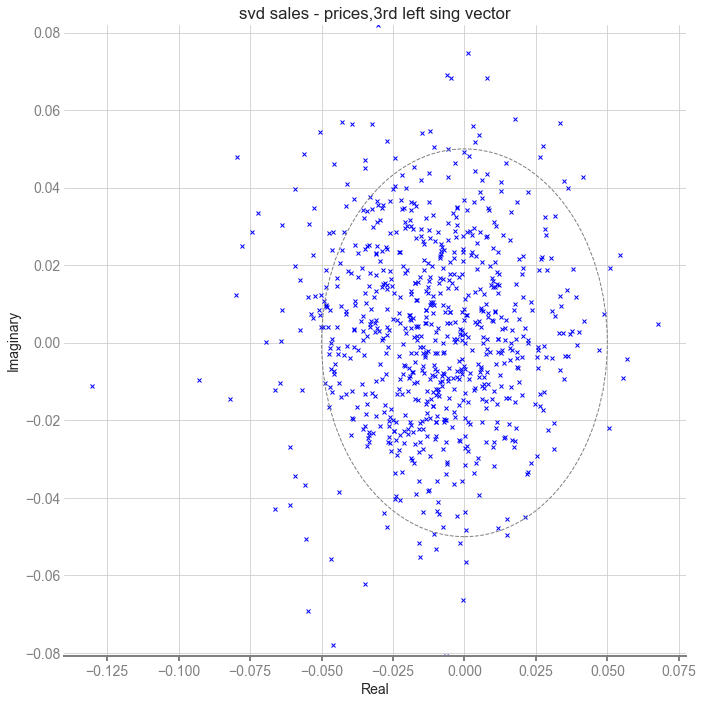

In [776]:
plotting_complex_plane(v.T[:,1], title = "svd sales - prices,3rd left sing vector")

simple analytical toy-model to get intuition of the problem

$s(t) = \cos(\omega t) $

<math>\begin{align}
\hat{s}(t) &= \cos\left(\omega t - \frac{\pi}{2}\right) = \sin(\omega t), \\
s_\mathrm{a}(t) &= s(t) + j\hat{s}(t) = \cos(\omega t) + j\sin(\omega t) = e^{j\omega t}
\end{align}</math>


$s(t) = \cos(\omega t + \theta) = \frac{1}{2} \left(e^{j (\omega t+\theta)} + e^{-j (\omega t+\theta)}\right)$

$s_\mathrm{a}(t) = $
<math>\begin{cases}
e^{j(\omega t + \theta)} \ \ = \ e^{j |\omega| t}\cdot e^{j\theta} , & \text{if} \ \omega  > 0, \\
e^{-j(\omega t + \theta)} = \ e^{j |\omega| t}\cdot e^{-j\theta} , & \text{if} \ \omega  < 0.
\end{cases}
</math>



To compute the correlation between two signals, we need to calculate the cross-correlation function. In this case, we have two signals:

$s_1(t) = e^{jwt}$


$s_2(t) = e^{j(wt + \theta)}$

the complex conjugate of $s_2$, denoted as $s_2^*$ is:

$s_2^*(t) = e^{-j(wt + \theta)}$


Now, we can compute the correlation by taking the expectation value of the product of $s_1$ and the complex conjugate of $s_2$, denoted as $s_2^*$.

$C_{1,2} = \langle s_1(t) s_2^*(t) \rangle$

To calculate this, we integrate the product of $s_1$ and $s_2^*$ over a period of time and average the result.

$= \frac{1}{T} \int_{0}^{T} s_1(t) s_2^*(t) dt$


$= \frac{1}{T} \int_{0}^{T} e^{jwt} e^{-j(wt + \theta)} dt$

Since $e^{j\theta} e^{-j\theta} = 1$, 

$= \frac{1}{T} \int_{0}^{T} e^{jwt - jwt - j\theta} dt$


$= \frac{1}{T} \left[ e^{-j\theta} t \right]_{0}^{T}$


$= \frac{1}{T} \left( e^{-j\theta} T - e^{-j\theta} 0 \right)$


$= e^{-j\theta}$


Similarly, we can compute the correlation for $s_1 s_1$ and $s_2 s_2$ by substituting the appropriate expressions:

The correlation matrix for $s_1$ and $s_2$ is given by:

$\mathbf{C} = 
\begin{bmatrix}
1 & e^{-j\theta} \\
e^{+j\theta} & 1
\end{bmatrix}$

$
\mathbf{C} = 
\begin{bmatrix}
1 & e^{-j\theta} \\
e^{j\theta} & 1
\end{bmatrix}
$

To find the eigenvectors and eigenvalues, we solve the equation:

$
(\mathbf{C} - \lambda\mathbf{I})\mathbf{x} = 0
$

where $\mathbf{C}$ is the correlation matrix, $\lambda$ is the eigenvalue, $\mathbf{I}$ is the identity matrix, and $\mathbf{x}$ is the eigenvector.

First, let's find the eigenvalues:

$
|\mathbf{C} - \lambda\mathbf{I}| = 
\begin{vmatrix}
1-\lambda & e^{-j\theta} \\
e^{j\theta} & 1-\lambda
\end{vmatrix}
$

Expanding the determinant, we get:

$
(1 - \lambda)(1 - \lambda) - e^{j\theta}e^{-j\theta} = 0
$

Simplifying, we find two possible eigenvalues:
1) $\lambda_1 = 2$

2) $\lambda_2 = 0$

Next, let's find the eigenvectors associated with each eigenvalue.

1) For $\lambda_1 = 2$:

$
(\mathbf{C} - 2\mathbf{I})\mathbf{x} = 0
$

$
\begin{bmatrix}
-1 & e^{-j\theta} \\
e^{j\theta} & -1
\end{bmatrix}
\mathbf{x} = 0
$

From the first equation, we can express $x_2$ in terms of $x_1$:

$
x_2 = e^{-j\theta}x_1
$

Substituting this into the second equation, we have:

$
e^{j\theta}x_1 - x_1 = 0
$

So the eigenvector for $\lambda_1 = 2$ is:

$
\mathbf{x}_1 = \begin{bmatrix} x_1 \\ e^{-j\theta}x_1 \end{bmatrix} \text{, where } x_1 \neq 0 \text{ and } e^{j\theta} \neq 1
$

2) For $\lambda_2 = 0$:

$
(\mathbf{C} - 0\mathbf{I})\mathbf{x} = 0
$

$
\begin{bmatrix}
1 & e^{-j\theta} \\
e^{j\theta} & 1
\end{bmatrix}
\mathbf{x} = 0
$

From the first equation, we can express $x_2$ in terms of $x_1$:

$
x_2 = -e^{-j\theta}x_1
$

Substituting this into the second equation, we have:

$
e^{j\theta}x_1 + x_1 = 0
$

So the eigenvector for $\lambda_2 = 0$ is:

$
\mathbf{x}_2 = \begin{bmatrix} x_1 \\ -e^{-j\theta}x_1 \end{bmatrix} \text{, where } x_1 \neq 0 \text{ and } e^{j\theta} \neq -1
$


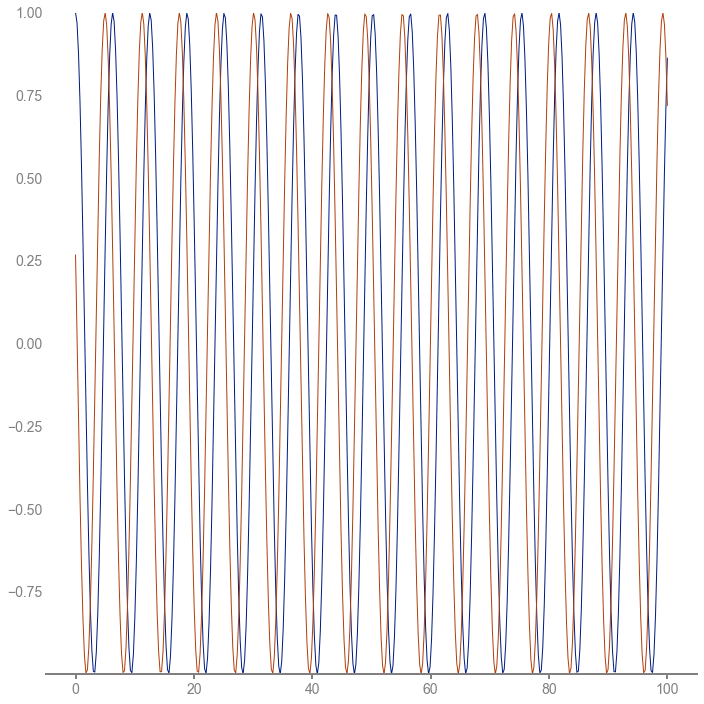

            0         1
0    1.000000  0.267499
1    0.968757  0.020168
2    0.876981 -0.228422
3    0.730406 -0.462740
4    0.538192 -0.668143
..        ...       ...
395  0.037316  0.972869
396  0.283989  0.999853
397  0.512916  0.964360
398  0.709793  0.868609
399  0.862319  0.718582

[400 rows x 2 columns]


In [764]:
x = np.linspace(0,100, num = 400)
θ = 1.3
series1 = np.cos(x)
series2 = np.cos(x + θ)
an_series = np.column_stack((series1, series2))

plt.plot(x, series1)
plt.plot(x, series2)
plt.show()
print(pd.DataFrame(an_series))

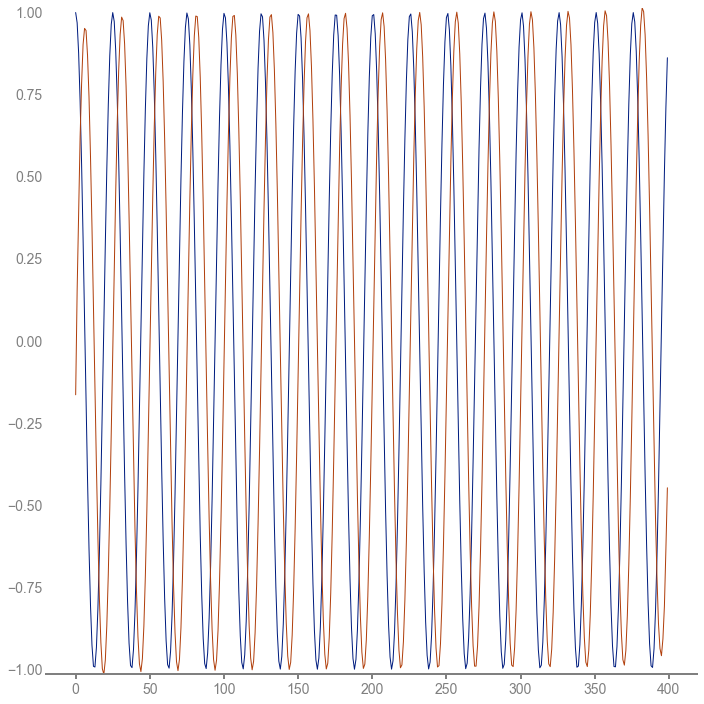

In [765]:
plt.plot(series1)
plt.plot(hilbert(series1).imag)

In [766]:
an_corr_complex, an_eval, an_evec = cpca(an_series)
#plotting_complex_plane(an_evec[:,1])
an_eval

array([1.99977795e+00+0.j, 2.22052373e-04+0.j])

### Synthetic time series

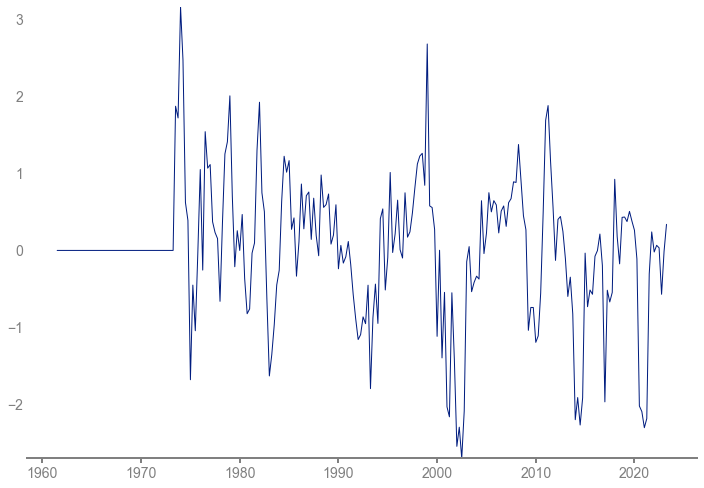

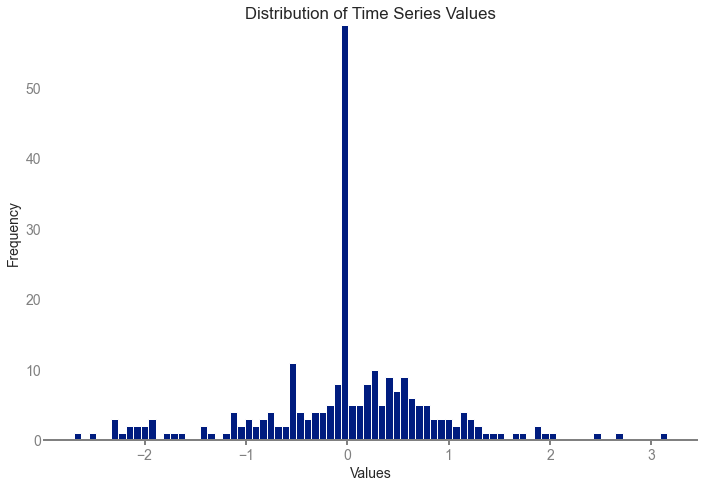

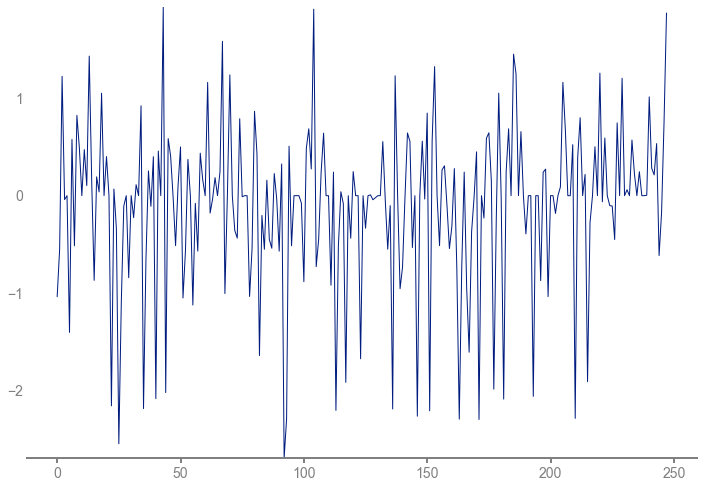

In [51]:
plt.plot(returns_sales[1004])
plot_distribution(returns_sales[1004])
synthetic_time_series = generate_sample_time_series(returns_sales[1004])
plt.plot(synthetic_time_series)

- Sampling

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


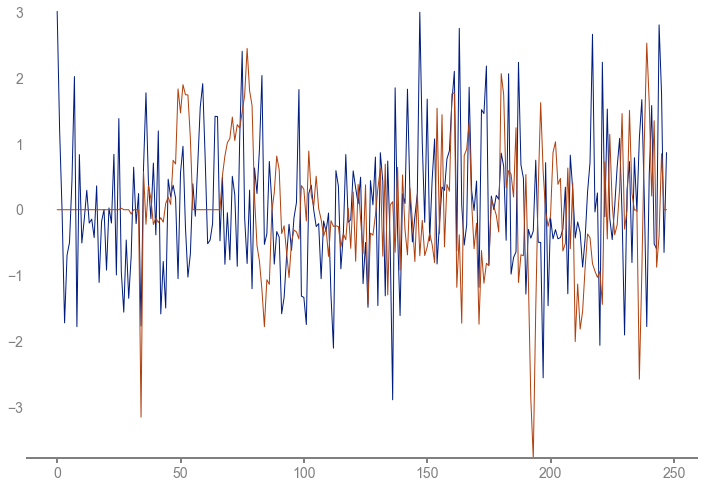

In [52]:
returns_syn = synthetic_returns_sampling(returns_sales, eVec_s)

# Example
plt.plot(returns_syn[:,2])
plt.plot(returns_sales[1062].values)

In [53]:
returns_syn = pd.DataFrame(returns_syn)
corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
corr_sy

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.000000,0.103334,-0.001038,-0.016217,0.005796,-0.008865,0.009502,0.034145,-0.026759,0.047546,...,0.137571,-0.008172,0.005384,0.086759,0.027962,0.023284,-0.016137,-0.069169,0.009801,0.022969
1,0.103334,1.000000,0.050044,-0.021769,-0.053668,0.189547,-0.209338,0.067529,0.045987,0.014102,...,0.009231,-0.112890,0.097705,-0.066781,-0.102780,0.068228,0.050577,-0.057041,0.114129,0.153477
2,-0.001038,0.050044,1.000000,0.204373,-0.552859,0.476897,0.030644,-0.258569,-0.161719,-0.311737,...,0.006346,0.063381,0.098185,0.052309,-0.148331,-0.128378,-0.033176,-0.145420,-0.092676,0.191157
3,-0.016217,-0.021769,0.204373,1.000000,-0.684231,0.275093,-0.048657,0.044242,0.048281,-0.268783,...,0.091200,0.013788,0.128773,-0.029511,-0.150895,0.113069,-0.176225,0.052365,0.016554,0.008148
4,0.005796,-0.053668,-0.552859,-0.684231,1.000000,-0.547261,0.303323,-0.122485,0.087959,0.331548,...,-0.136388,-0.046028,-0.203561,0.019243,0.265757,-0.048391,0.137078,0.017162,-0.048227,-0.060714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.023284,0.068228,-0.128378,0.113069,-0.048391,0.020416,-0.011495,-0.172588,0.197363,-0.054773,...,0.132416,-0.024814,0.104751,-0.191327,-0.181103,1.000000,-0.230665,0.051245,0.176610,0.010855
764,-0.016137,0.050577,-0.033176,-0.176225,0.137078,-0.126167,-0.038102,-0.008304,-0.042923,-0.029467,...,0.006423,0.075532,-0.227743,-0.157010,0.153113,-0.230665,1.000000,-0.070214,-0.067911,0.312332
765,-0.069169,-0.057041,-0.145420,0.052365,0.017162,0.135489,0.064823,-0.106624,0.218125,-0.036277,...,-0.139834,-0.062949,0.102207,-0.071184,-0.203339,0.051245,-0.070214,1.000000,0.115344,-0.150659
766,0.009801,0.114129,-0.092676,0.016554,-0.048227,-0.071659,0.026129,-0.056021,0.105138,-0.016847,...,-0.007645,0.063519,0.060367,-0.296535,-0.192342,0.176610,-0.067911,0.115344,1.000000,0.011236


In [54]:
distance = []
for _ in range(160):
    returns_syn = synthetic_returns_sampling(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance.append(spectral_distance_metric(eVec_s, eVec_sy, n=15))

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


In [55]:
distance1 = []
for _ in range(160):
    returns_syn = synthetic_returns_sampling(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance1.append(spectral_distance_metric(eVec_s, eVec_sy, n=4))

------

In order to compute the distance between the eigenspace of the same companies share prices instead of the sales. We should import the same data paying heet to keep the same companies data.



In [56]:
import src.csv_data.extract as ex
df = ex.extract_data('/Users/pietrobicocchi/Desktop/project/' + 'data/CompStat/crsp_ccm_inventories_sales.csv')
sales, prices = df_to_sales(df)

In [57]:
sales_keys = returns_sales.keys()
tailored_prices = tailored_clean(prices, sales_keys)
tailored_prices

corr_tail_sales = tailored_prices.corr(method= 'pearson', min_periods=8)
eVal_tail_p , eVec_tail_p = getPCA(corr_tail_sales)

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [58]:
distance_sales_prices = spectral_distance_metric(eVec_s, eVec_tail_p, n=15)

------

Text(0.5, 1.0, 'Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors')

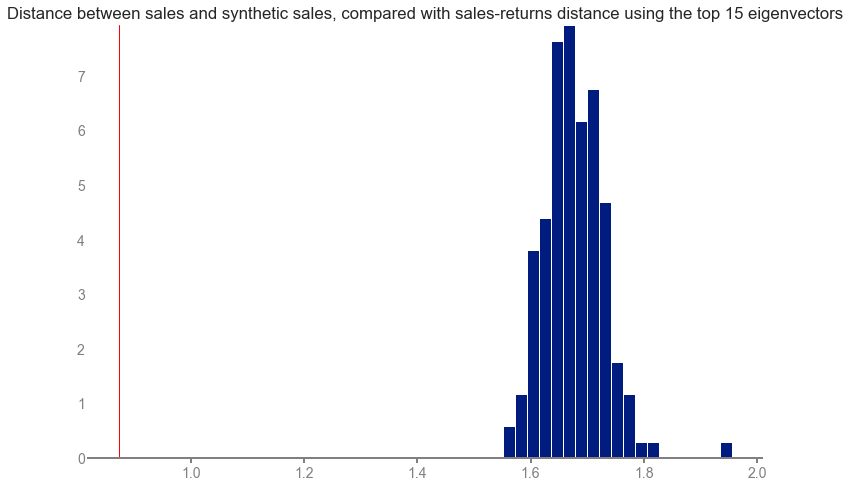

In [59]:
plt.hist(distance, bins = np.linspace(np.min(distance), np.max(distance), 20), density=True)
plt.axvline(distance_sales_prices, color='r')
plt.title("Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors")

Text(0.5, 1.0, 'Distance between sales and synthetic sales, compared with sales-returns distance using the top 4 eigenvectors')

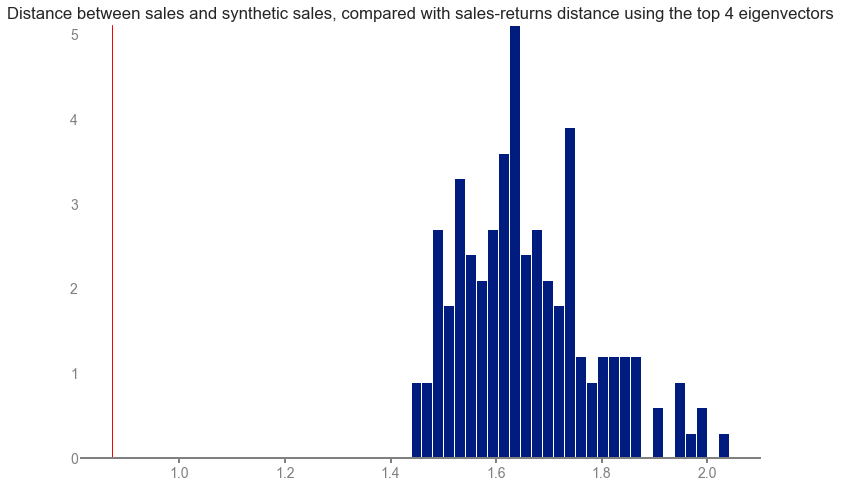

In [60]:
plt.hist(distance1, bins = np.linspace(np.min(distance1), np.max(distance1), 30), density=True)
plt.axvline(distance_sales_prices, color='r')
plt.title("Distance between sales and synthetic sales, compared with sales-returns distance using the top 4 eigenvectors")

I'm plotting a vertical line for the sales-prices eigenspace distance. (it should be measured for the same companies)

two cases 
> if the line is outside the distribution we can safely assume that the sales and the prices have different generative processes 

> if the line is inside the distribution, it could be a sign of the fact that sales and prices have the same generative process

- Shuffling

To cast the problem in a linear algebra fashion, let's define the given information and steps using matrices and vectors.

1. Returns Time Series:
Let's say we have a returns time series represented as a matrix, denoted by X. Each column of X represents the returns of a specific asset or variable, and each row represents a different time period. So, X has dimensions N x M, where N is the number of time periods and M is the number of assets/variables.

2. Sample Correlation Matrix:
We compute the sample correlation matrix, denoted by C, by calculating the correlation coefficients between the returns of all pairs of assets. C is an M x M square matrix, where each entry C(i, j) represents the correlation between the ith and jth assets.

3. Eigendecomposition:
We perform the eigendecomposition of the correlation matrix C, which gives us a set of eigenvectors and eigenvalues. Let's denote the eigenvectors as V and the eigenvalues as λ. V is an M x M matrix, where each column represents an eigenvector, and λ is an M-dimensional vector containing the eigenvalues.

4. Projection onto Eigenspace:
We project the returns time series (X) onto the eigenspace spanned by the eigenvectors V. This projection yields a new matrix Y, which represents the coordinates of the returns time series in the eigenspace. Y is obtained by multiplying X with V, i.e., Y = X * V.

5. Shuffle Projection Components:
For each mode (eigenvalue-eigenvector pair), we shuffle the components of the projection matrix Y. Let's denote the shuffled projection matrix as Y_shuffle.

6. Generate Synthetic Time Series:
To generate synthetic time series, we reconstruct the shuffled projection matrix Y_shuffle using the eigenvectors V. Let's denote the reconstructed matrix as X_synthetic, which has the same dimensions as the original returns time series X.

7. Recompute Correlation Matrix:
Finally, we recompute the correlation matrix for the synthetic time series X_synthetic, obtaining a new correlation matrix C_synthetic.

In summary, we have:

Original Data:
Returns Time Series: X (N x M)
Correlation Matrix: C (M x M)

Eigendecomposition:
Eigenvectors: V (M x M)
Eigenvalues: λ (M-dimensional vector)

Projection onto Eigenspace:
Projected Matrix: Y = X * V (N x M)

Shuffle Projection Components:
Shuffled Projection Matrix: Y_shuffle (N x M)

Synthetic Time Series:
Reconstructed Matrix: X_synthetic = Y_shuffle * V^T (N x M)

Recomputed Correlation Matrix:
Correlation Matrix for Synthetic Time Series: C_synthetic (M x M)

Note that the eigenvectors are typically orthogonal, which allows us to reconstruct the synthetic time series by multiplying the shuffled projection matrix by the transposed eigenvectors. This assumes that the eigenvectors form an orthonormal basis.

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


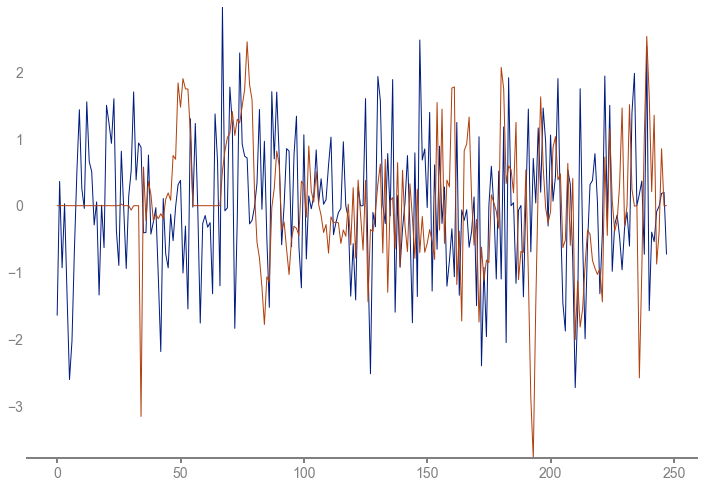

In [61]:
returns_syn = synthetic_returns_shuffling(returns_sales, eVec_s)

# Example
plt.plot(returns_syn[:,2])
plt.plot(returns_sales[1062].values)

the synthetic series generated using the shuffled projection components and reconstructed using eigenvectors should exhibit similar correlation structure and preserve some statistical properties of the original data. However, it may not capture specific patterns or details that are not explained by the major modes of correlation captured by the eigenvectors. The extent of similarity between the synthetic series and the original data will depend on the number of eigenvectors used and their corresponding eigenvalues, as well as the nature of the data and the specific patterns present in it.

In [62]:
returns_syn = pd.DataFrame(returns_syn)
corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
corr_sy

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.000000,-0.021962,-0.209675,0.099395,0.145629,-0.182671,0.150800,-0.310889,0.295280,0.048812,...,0.063209,-0.087953,0.024418,-0.041941,-0.063984,0.084503,-0.055556,0.012629,0.114361,-0.080040
1,-0.021962,1.000000,0.031456,0.046177,-0.080685,0.230251,-0.179993,0.052932,0.059834,0.035028,...,-0.014643,-0.070736,0.020907,0.003600,-0.089217,0.013507,-0.031094,0.007410,0.002764,0.281939
2,-0.209675,0.031456,1.000000,0.213763,-0.505642,0.464322,-0.018508,-0.268882,-0.190941,-0.267926,...,-0.040639,-0.004995,0.133966,-0.007722,-0.253980,-0.155607,0.040970,-0.114565,-0.044553,0.175427
3,0.099395,0.046177,0.213763,1.000000,-0.717008,0.340644,-0.067014,-0.001920,0.116699,-0.278504,...,0.096735,-0.052596,0.188539,-0.198809,-0.212572,0.118178,-0.102623,0.036285,0.070301,0.002941
4,0.145629,-0.080685,-0.505642,-0.717008,1.000000,-0.585867,0.317205,-0.030752,-0.038312,0.320816,...,-0.021704,0.031038,-0.254273,0.202397,0.407107,-0.108211,0.068189,0.006400,-0.072274,-0.136666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.084503,0.013507,-0.155607,0.118178,-0.108211,-0.024769,-0.091114,-0.033836,0.148170,-0.100101,...,0.154511,0.010978,0.057868,-0.209115,-0.087879,1.000000,-0.183088,-0.016327,0.142217,0.064036
764,-0.055556,-0.031094,0.040970,-0.102623,0.068189,-0.047333,-0.016446,-0.020233,-0.145066,0.008211,...,0.023681,0.092936,-0.093482,-0.023584,0.042315,-0.183088,1.000000,-0.082846,-0.063296,0.219568
765,0.012629,0.007410,-0.114565,0.036285,0.006400,0.134982,-0.030609,0.051951,0.220238,-0.168693,...,-0.103786,-0.059839,0.069468,0.155691,-0.169068,-0.016327,-0.082846,1.000000,-0.003341,-0.004958
766,0.114361,0.002764,-0.044553,0.070301,-0.072274,-0.041168,0.028234,-0.043243,0.096721,-0.066518,...,0.029465,-0.014166,-0.003189,-0.204602,-0.200869,0.142217,-0.063296,-0.003341,1.000000,0.062606


In [64]:
distance = []
for _ in range(20):
    returns_syn = synthetic_returns_shuffling(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance.append(spectral_distance_metric(eVec_s, eVec_sy, n=15))

/Users/pietrobicocchi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:1587: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = arr.astype(dtype, copy=False)


Text(0.5, 1.0, 'Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors')

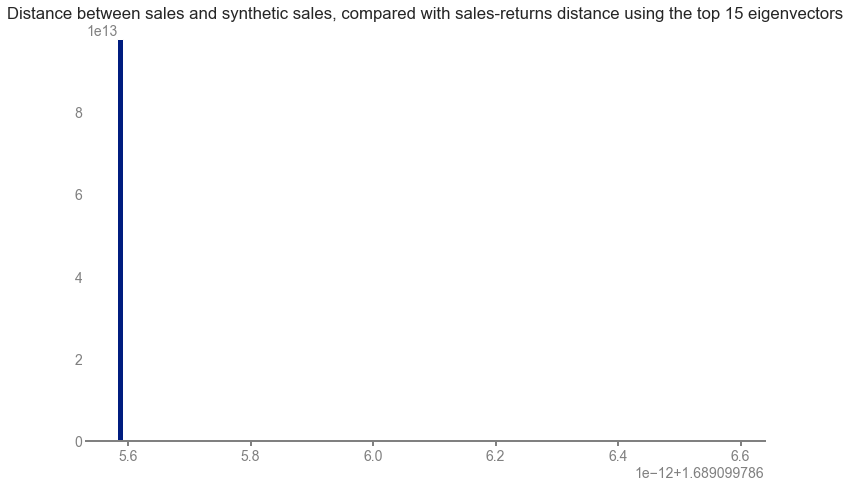

In [70]:
plt.hist(distance, bins = np.linspace(np.min(distance), np.max(distance)+1e-12, 100), density=True)
#plt.axvline(distance_sales_prices, color='r')
plt.title("Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors")

- Shuffling in blocks

In [120]:
import random

def shuffle_by_blocks(seq, blocksize):
    blocks = [seq[idx*blocksize: (idx+1)*blocksize] for idx in range(len(seq)//blocksize)]
    random.shuffle(blocks)
    return [elt for block in blocks for elt in block ]

In [121]:
def synthetic_returns_shuffling_in_blocks(returns, eigenvectors, size_block = 8):
    # Project onto Eigenspace
    Y = mode_coefficient_matrix(returns)

    # Shuffle Projection Components
    Y_shuffle = Y.copy()  # Copy the projected matrix
    
    # Shuffling in blocks
    new_index = shuffle_by_blocks(list(range(np.shape(Y_shuffle)[0])), size_block)
    Y_shuffle = Y_shuffle[new_index, :]
    
    # Generate Synthetic Time Series
    X_synthetic = np.dot(Y_shuffle, np.linalg.inv(eigenvectors))

    return X_synthetic

In [124]:
distance = []
for _ in range(150):
    returns_syn = synthetic_returns_shuffling_in_blocks(returns_sales, eVec_s)
    returns_syn = pd.DataFrame(returns_syn)
    corr_sy = returns_syn.corr(method= 'pearson', min_periods=8)
    eVal_sy , eVec_sy = getPCA(corr_sy)

    distance.append(spectral_distance_metric(eVec_s, eVec_sy, n=5))

Text(0.5, 1.0, 'Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors')

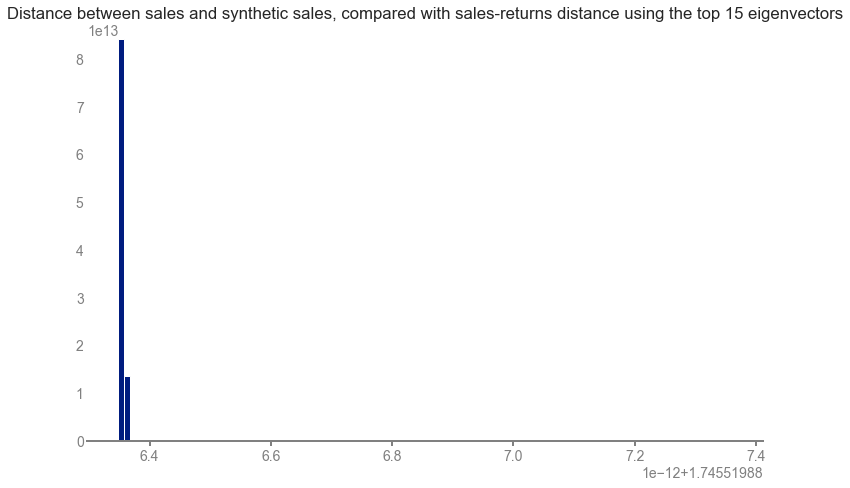

In [127]:
plt.hist(distance, bins = np.linspace(np.min(distance), np.max(distance)+1e-12, 100), density=True)
#plt.axvline(distance_sales_prices, color='r')
plt.title("Distance between sales and synthetic sales, compared with sales-returns distance using the top 15 eigenvectors")

In [688]:
path_clean_gdp = '/Users/pietrobicocchi/Desktop/project/data/GDPC1.csv'
pd.read_csv(path_clean_gdp)

,DATE,GDPC1
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442
...,...,...
300,2022-01-01,19924.088
301,2022-04-01,19895.271
302,2022-07-01,20054.663
303,2022-10-01,20182.491


### Prediction

In [22]:
returns_sales
tailored_prices

GVKEY,1004,1045,1062,1072,1075,1076,1078,1104,1121,1161,...,11669,11670,11672,11687,13003,13714,14253,15106,15247,28590
datadate,,,,,,,,,,,,,,,,,,,,,
1961-06-30,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1961-09-30,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1961-12-31,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1962-03-31,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1962-06-30,0.000000,0.000000,0.000000,0.0,-3.091180,0.000000,-1.175047,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-3.140166,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,1.427379,0.121011,0.335132,0.0,0.861575,-2.122119,-1.002769,-0.002950,1.159206,-0.755633,...,0.0,-0.365167,0.387649,0.158538,0.0,0.916577,0.235350,0.000000,1.243955,0.156622
2022-06-30,0.306392,-1.006599,-0.882245,0.0,-0.605313,-2.624116,-0.499800,-0.334524,-0.724011,-0.975517,...,0.0,-0.214954,-0.763567,-1.201859,0.0,-1.737742,-0.596878,0.000000,0.141293,-0.663271
2022-09-30,-0.540051,-0.080124,-1.299061,0.0,-1.127045,-0.452956,-0.673797,-1.635473,-0.344204,-0.525981,...,0.0,-1.928528,-0.046907,-0.019855,0.0,-1.057326,-0.463177,0.000000,-0.032270,-1.278420


In [23]:
# Singular Value Selection (if required)
k = 3  # Number of desired singular values to retain
u_k = u[:, :k]  # Select the top k columns of 'u'
s_k = np.diag(s[:k])  # Select the top k singular values and form a diagonal matrix
v_k = v[:k, :]  # Select the top k rows of 'v'

In [24]:
s_k

array([[26.47858272,  0.        ,  0.        ],
       [ 0.        , 15.04226336,  0.        ],
       [ 0.        ,  0.        ,  9.54203634]])

In [26]:
# Dimensionality Reduction
reconstructed_matrix = u_k.dot(s_k).dot(v_k)  # Reconstruct the reduced matrix

In [36]:
# Prepare the data for regression model
tau = 2
X = returns_sales  # Independent variables (sales)
y = tailored_prices[tau:] # Dependent variable (prices)

In [ ]:
# Step 5: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Step 6: Fit the regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Step 7: Predict sales growth using the regression model
y_pred = reg_model.predict(X_test)

# Step 8: Evaluate the performance of the regression model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse) 